In [ ]:
import numpy as np
import math
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
cuda

True

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = math.ceil(img_size / 2 ** 4)
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

print(count_parameters(generator))
print(count_parameters(discriminator))

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|     l1.0.weight      |   627200   |
|      l1.0.bias       |    6272    |
| conv_blocks.0.weight |    128     |
|  conv_blocks.0.bias  |    128     |
| conv_blocks.2.weight |   147456   |
|  conv_blocks.2.bias  |    128     |
| conv_blocks.3.weight |    128     |
|  conv_blocks.3.bias  |    128     |
| conv_blocks.6.weight |   73728    |
|  conv_blocks.6.bias  |     64     |
| conv_blocks.7.weight |     64     |
|  conv_blocks.7.bias  |     64     |
| conv_blocks.9.weight |    576     |
|  conv_blocks.9.bias  |     1      |
+----------------------+------------+
Total Trainable Params: 856065
856065
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|   model.0.weight   |    144     |
|    model.0.bias    |     16     |
|   model.3.weight   |    4608    |
|    model.3.bias    |     32     |
|   model.6.weight   |    

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 136473100.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39522249.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37045581.33it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19761959.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size()

torch.Size([1, 28, 28])

In [ ]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

In [ ]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



  0%|          | 0/235 [00:00<?, ?it/s]

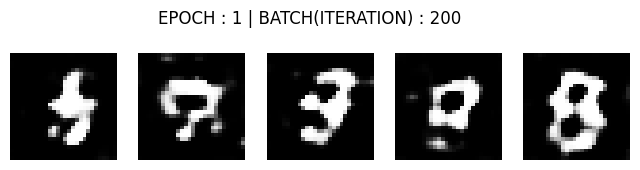

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.687802] [G loss: 0.780016]


  0%|          | 0/235 [00:00<?, ?it/s]

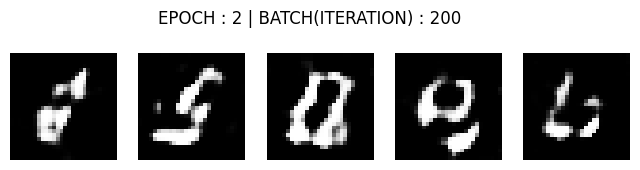

[Epoch: 2/25] [Batch: 235/235] [D loss: 0.687850] [G loss: 0.722680]


  0%|          | 0/235 [00:00<?, ?it/s]

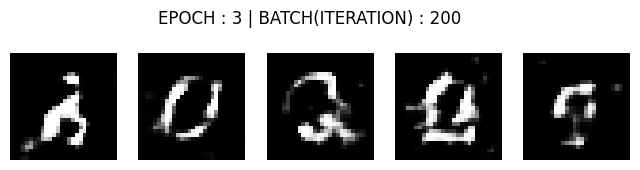

[Epoch: 3/25] [Batch: 235/235] [D loss: 0.656868] [G loss: 0.706700]


  0%|          | 0/235 [00:00<?, ?it/s]

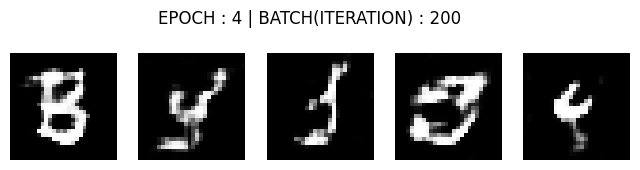

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.651365] [G loss: 0.772397]


  0%|          | 0/235 [00:00<?, ?it/s]

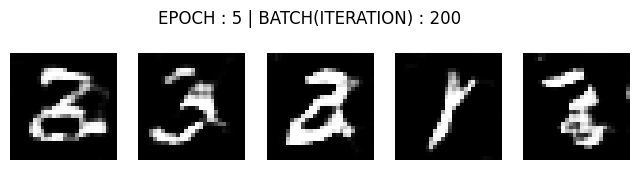

[Epoch: 5/25] [Batch: 235/235] [D loss: 0.648690] [G loss: 0.715596]


  0%|          | 0/235 [00:00<?, ?it/s]

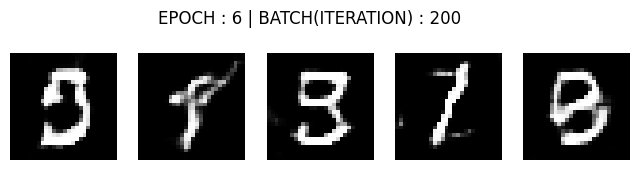

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.587253] [G loss: 0.796667]


  0%|          | 0/235 [00:00<?, ?it/s]

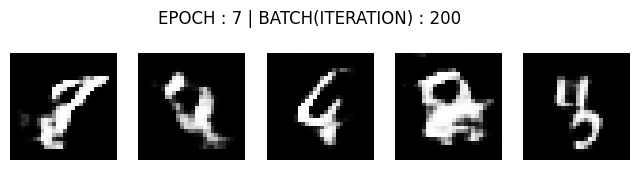

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.638895] [G loss: 0.974999]


  0%|          | 0/235 [00:00<?, ?it/s]

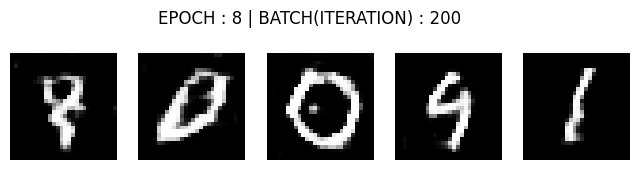

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.648638] [G loss: 0.979831]


  0%|          | 0/235 [00:00<?, ?it/s]

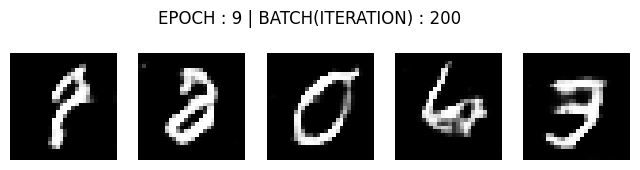

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.572031] [G loss: 0.970815]


  0%|          | 0/235 [00:00<?, ?it/s]

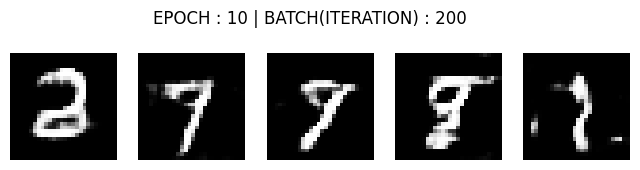

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.598956] [G loss: 0.824882]


  0%|          | 0/235 [00:00<?, ?it/s]

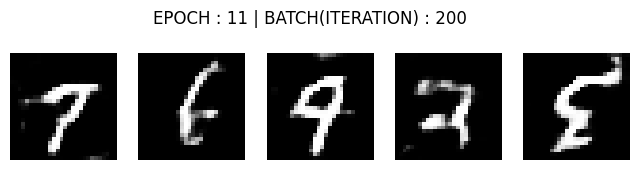

[Epoch: 11/25] [Batch: 235/235] [D loss: 0.630417] [G loss: 0.842459]


  0%|          | 0/235 [00:00<?, ?it/s]

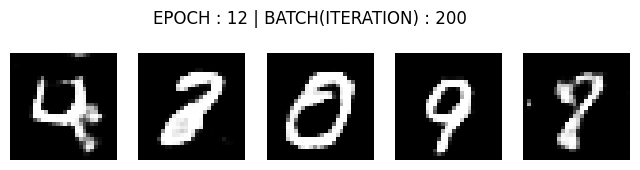

[Epoch: 12/25] [Batch: 235/235] [D loss: 0.561315] [G loss: 0.810894]


  0%|          | 0/235 [00:00<?, ?it/s]

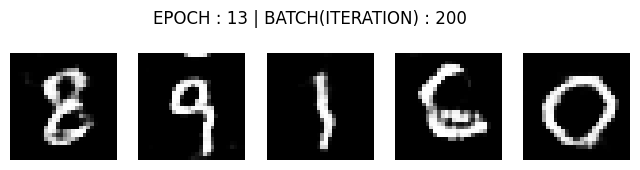

[Epoch: 13/25] [Batch: 235/235] [D loss: 0.529334] [G loss: 1.240665]


  0%|          | 0/235 [00:00<?, ?it/s]

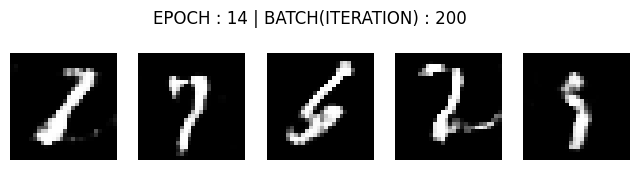

[Epoch: 14/25] [Batch: 235/235] [D loss: 0.542962] [G loss: 1.203608]


  0%|          | 0/235 [00:00<?, ?it/s]

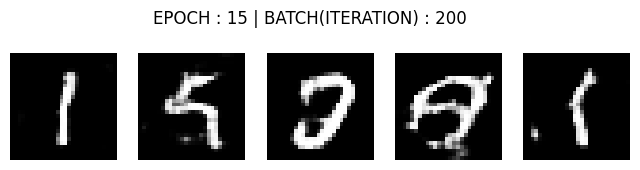

[Epoch: 15/25] [Batch: 235/235] [D loss: 0.643449] [G loss: 0.891785]


  0%|          | 0/235 [00:00<?, ?it/s]

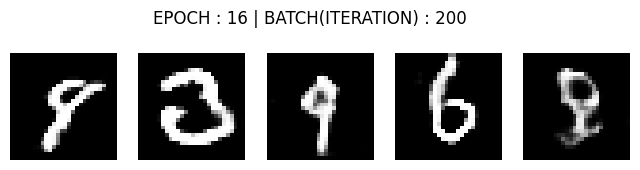

[Epoch: 16/25] [Batch: 235/235] [D loss: 0.513805] [G loss: 0.994362]


  0%|          | 0/235 [00:00<?, ?it/s]

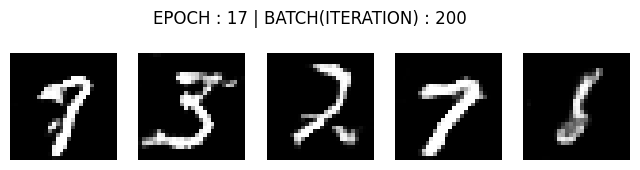

[Epoch: 17/25] [Batch: 235/235] [D loss: 0.597697] [G loss: 0.592300]


  0%|          | 0/235 [00:00<?, ?it/s]

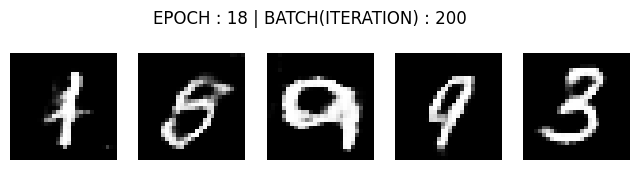

[Epoch: 18/25] [Batch: 235/235] [D loss: 0.465655] [G loss: 0.847074]


  0%|          | 0/235 [00:00<?, ?it/s]

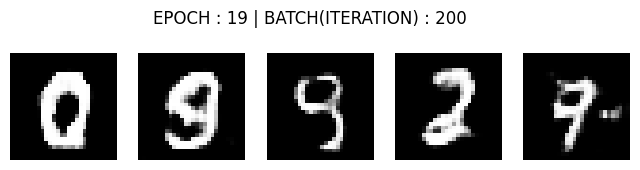

[Epoch: 19/25] [Batch: 235/235] [D loss: 0.603217] [G loss: 0.999167]


  0%|          | 0/235 [00:00<?, ?it/s]

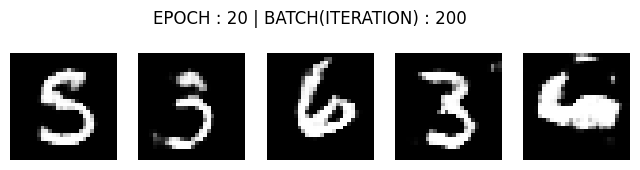

In [ ]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape


torch.Size([64, 100])

In [ ]:
# generated images
sample_gen_imgs = generator(sample_z).detach().cpu()
sample_gen_imgs.shape


torch.Size([64, 1, 28, 28])

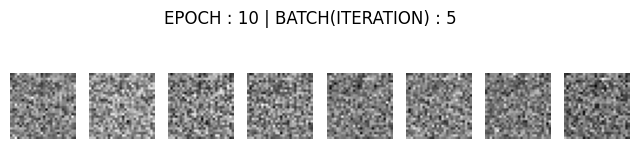

In [ ]:
nrow=1
ncols=8
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs.permute(0,2,3,1)[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

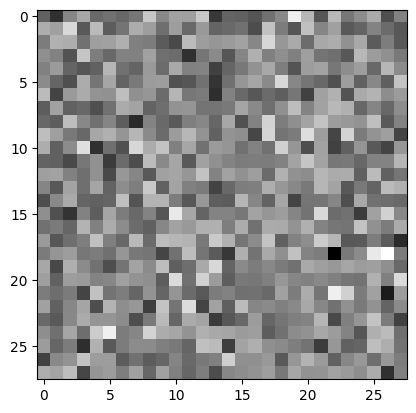

In [ ]:
show(sample_gen_imgs[1, :, :, :].detach())

In [ ]:
sample_gen_imgs[0, :, :, :].detach().shape

torch.Size([1, 28, 28])

In [ ]:
sample_gen_imgs

tensor([[[[-2.8368e-02, -5.5489e-02, -2.7350e-02,  ...,  3.6327e-02,
           -2.0238e-02, -5.6542e-03],
          [-1.9525e-02,  2.4612e-02,  1.0359e-02,  ...,  9.7200e-04,
           -1.3957e-02, -2.6984e-02],
          [-9.3862e-03,  1.3547e-02,  2.0596e-02,  ..., -1.5536e-02,
           -3.0833e-02,  3.2126e-03],
          ...,
          [ 7.7960e-03, -2.8259e-02, -2.3510e-02,  ...,  2.2382e-02,
            2.8663e-02,  2.6928e-02],
          [-6.7277e-03,  4.0350e-02, -5.7768e-03,  ...,  8.5601e-03,
            4.3665e-02, -1.0575e-02],
          [ 2.5678e-02,  2.4385e-02,  6.9989e-02,  ...,  4.2868e-02,
           -2.0829e-02,  5.9842e-03]]],


        [[[-2.6171e-02, -6.1379e-02,  8.2558e-04,  ...,  2.6550e-02,
           -3.9166e-02, -2.4341e-03],
          [ 2.9218e-02,  1.9246e-02,  5.9953e-02,  ..., -1.8948e-03,
           -1.9038e-02, -3.3475e-02],
          [-6.9842e-03,  3.2121e-02,  2.9149e-02,  ..., -3.0721e-02,
           -6.2239e-03, -3.3004e-02],
          ...,
   